In [15]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from lag_llama.gluon.estimator import LagLlamaEstimator
from huggingface_hub import hf_hub_download

d:\Projects\lagllama\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dataset = get_dataset("australian_electricity_demand") 
backtest_dataset = dataset.test 
prediction_length = dataset.metadata.prediction_length 
context_length = 3 * prediction_length

Download australian_electricity_demand_dataset.zip:: 5.51MB [00:01, 4.19MB/s]
creating json files: 100%|██████████| 5/5 [00:00<?, ?it/s]


In [10]:
torch.cuda.is_available()

True

In [11]:
torch.cuda.device_count()

1

In [12]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

In [17]:
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0')) 
estimator_args = ckpt["hyper_parameters"]["model_kwargs"] 

In [19]:
estimator = LagLlamaEstimator( ckpt_path="lag-llama.ckpt", 
  prediction_length=prediction_length, 
  context_length=context_length, 
  input_size=estimator_args["input_size"], 
  n_layer=estimator_args["n_layer"], 
  n_embd_per_head=estimator_args["n_embd_per_head"], 
  n_head=estimator_args["n_head"], 
  scaling=estimator_args["scaling"], 
  time_feat=estimator_args["time_feat"]) 

lightning_module = estimator.create_lightning_module() 
transformation = estimator.create_transformation() 
predictor = estimator.create_predictor(transformation, lightning_module) 

In [20]:
forecast_it, ts_it = make_evaluation_predictions(
  dataset=backtest_dataset, 
  predictor=predictor) 

In [21]:
forecasts = list(forecast_it) 
tss = list(ts_it) 

d:\Projects\lagllama\lag-llama\lag_llama\model\module.py:315: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  y = F.scaled_dot_product_attention(


In [22]:
evaluator = Evaluator() 

agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 5it [00:00, 55.24it/s]


In [23]:
agg_metrics

{'MSE': 259754.59658854167,
 'abs_error': 68340.07495117188,
 'abs_target_sum': 998149.748046875,
 'abs_target_mean': 3327.165826822916,
 'seasonal_error': 238.53778569914635,
 'MASE': 1.14449657471507,
 'MAPE': 0.10756936868031819,
 'sMAPE': 0.09816071073214214,
 'MSIS': 27.908472935532778,
 'QuantileLoss[0.1]': 105237.93766479492,
 'Coverage[0.1]': 0.03666666666666667,
 'QuantileLoss[0.2]': 113773.84336547853,
 'Coverage[0.2]': 0.14333333333333334,
 'QuantileLoss[0.3]': 104908.59960632323,
 'Coverage[0.3]': 0.21000000000000002,
 'QuantileLoss[0.4]': 84064.3139038086,
 'Coverage[0.4]': 0.3,
 'QuantileLoss[0.5]': 68340.07640075684,
 'Coverage[0.5]': 0.5133333333333333,
 'QuantileLoss[0.6]': 67543.26450195312,
 'Coverage[0.6]': 0.7233333333333334,
 'QuantileLoss[0.7]': 71187.05189208985,
 'Coverage[0.7]': 0.8766666666666667,
 'QuantileLoss[0.8]': 72570.87604980468,
 'Coverage[0.8]': 0.96,
 'QuantileLoss[0.9]': 63197.044964599576,
 'Coverage[0.9]': 1.0,
 'RMSE': 509.66125670737586,
 'NRM

In [25]:
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

CRPS: 0.08357942169374205


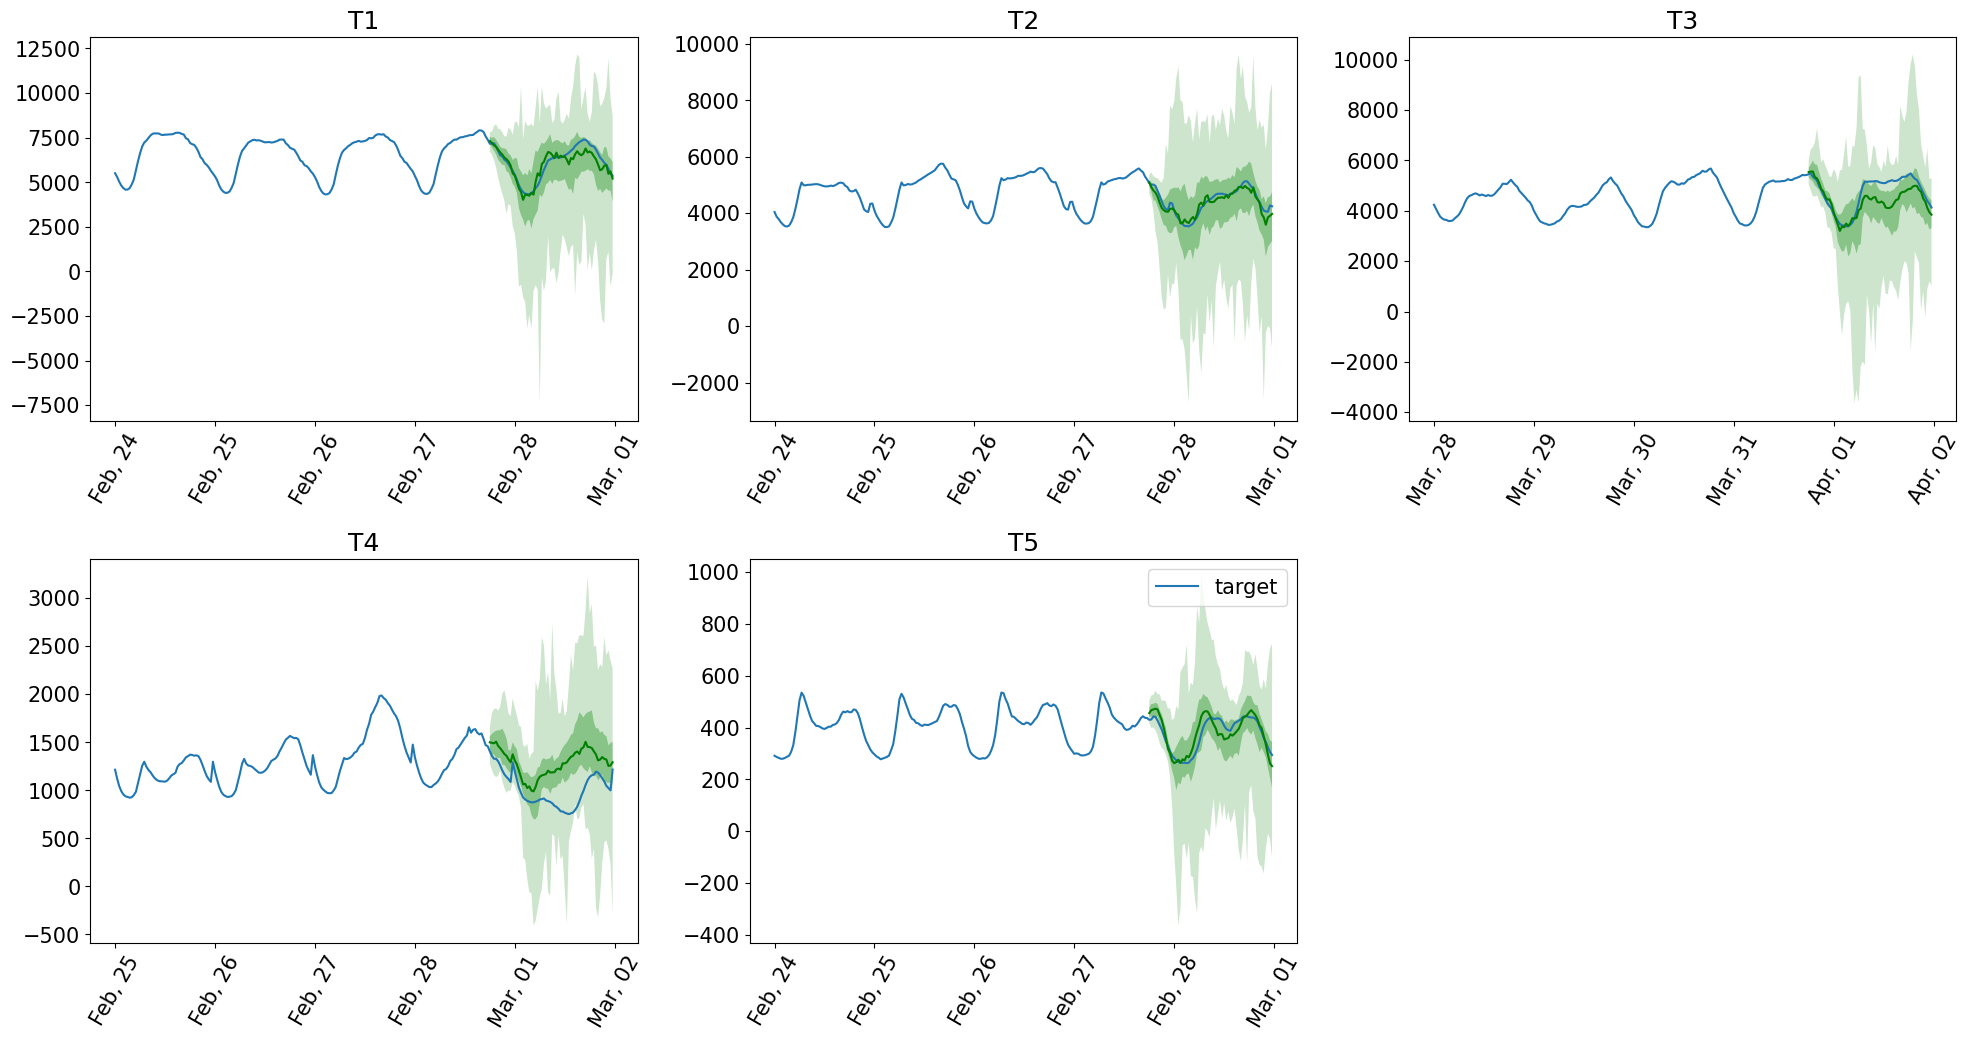

In [26]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [27]:
from gluonts.torch import TemporalFusionTransformerEstimator, DeepAREstimator 

tft_estimator = TemporalFusionTransformerEstimator(
  prediction_length=prediction_length, 
  context_length=context_length, 
  freq="30min", 
  trainer_kwargs={"max_epochs": 5}) 

deepar_estimator = DeepAREstimator(
  prediction_length=prediction_length, 
  context_length=context_length, 
  freq="30min", 
  trainer_kwargs={"max_epochs": 5}) 

In [28]:
tft_predictor = tft_estimator.train(dataset.train) 
deepar_predictor = deepar_estimator.train(dataset.train) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Projects\lagllama\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
d:\Projects\lagllama\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Co

Epoch 0: : 50it [02:58,  3.57s/it, v_num=0, train_loss=3.32e+3]

Epoch 0, global step 50: 'train_loss' reached 3317.90991 (best 3317.90991), saving model to 'd:\\Projects\\lagllama\\lag-llama\\lightning_logs\\version_0\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [02:47,  3.35s/it, v_num=0, train_loss=2.37e+3]

Epoch 1, global step 100: 'train_loss' reached 2369.83960 (best 2369.83960), saving model to 'd:\\Projects\\lagllama\\lag-llama\\lightning_logs\\version_0\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [02:52,  3.45s/it, v_num=0, train_loss=2.2e+3] 

Epoch 2, global step 150: 'train_loss' reached 2196.93115 (best 2196.93115), saving model to 'd:\\Projects\\lagllama\\lag-llama\\lightning_logs\\version_0\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [02:51,  3.42s/it, v_num=0, train_loss=1.95e+3]

Epoch 3, global step 200: 'train_loss' reached 1949.83911 (best 1949.83911), saving model to 'd:\\Projects\\lagllama\\lag-llama\\lightning_logs\\version_0\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: : 50it [02:56,  3.53s/it, v_num=0, train_loss=2.03e+3]

Epoch 4, global step 250: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 50it [02:56,  3.53s/it, v_num=0, train_loss=2.03e+3]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | In sizes | Out sizes   
----------------------------------------------------------------
0 | model | DeepARModel | 27.0 K | ?        | [1, 100, 60]
----------------------------------------------------------------
27.0 K    Trainable params
0         Non-trainable params
27.0 K    Total params
0.108     Total estimated model params size (MB)


Epoch 0: : 50it [02:49,  3.39s/it, v_num=1, train_loss=8.300]

Epoch 0, global step 50: 'train_loss' reached 8.29572 (best 8.29572), saving model to 'd:\\Projects\\lagllama\\lag-llama\\lightning_logs\\version_1\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [02:52,  3.45s/it, v_num=1, train_loss=7.140]

Epoch 1, global step 100: 'train_loss' reached 7.13748 (best 7.13748), saving model to 'd:\\Projects\\lagllama\\lag-llama\\lightning_logs\\version_1\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [02:47,  3.34s/it, v_num=1, train_loss=6.760]

Epoch 2, global step 150: 'train_loss' reached 6.76018 (best 6.76018), saving model to 'd:\\Projects\\lagllama\\lag-llama\\lightning_logs\\version_1\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [02:53,  3.48s/it, v_num=1, train_loss=6.530]

Epoch 3, global step 200: 'train_loss' reached 6.52900 (best 6.52900), saving model to 'd:\\Projects\\lagllama\\lag-llama\\lightning_logs\\version_1\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: : 50it [02:52,  3.45s/it, v_num=1, train_loss=6.520]

Epoch 4, global step 250: 'train_loss' reached 6.52447 (best 6.52447), saving model to 'd:\\Projects\\lagllama\\lag-llama\\lightning_logs\\version_1\\checkpoints\\epoch=4-step=250.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 50it [02:52,  3.45s/it, v_num=1, train_loss=6.520]


In [29]:
# Make predictions

tft_forecast_it, tft_ts_it = make_evaluation_predictions(
  dataset=backtest_dataset, 
  predictor=tft_predictor) 

deepar_forecast_it, deepar_ts_it = make_evaluation_predictions(
  dataset=backtest_dataset, 
  predictor=deepar_predictor) 

tft_forecasts = list(tft_forecast_it) 
tft_tss = list(tft_ts_it) 

deepar_forecasts = list(deepar_forecast_it) 
deepar_tss = list(deepar_ts_it) 

# Get evaluation metrics
tft_agg_metrics, tft_ts_metrics = evaluator(iter(tft_tss), iter(tft_forecasts)) 
deepar_agg_metrics, deepar_ts_metrics = evaluator(iter(deepar_tss), iter(deepar_forecasts)) 

Running evaluation: 5it [00:00, 77.54it/s]
Running evaluation: 5it [00:00, 111.04it/s]


In [32]:
print("CRPS:", deepar_agg_metrics['mean_wQuantileLoss'])

CRPS: 0.08772010473898285
